In [106]:
# import libraries

import pandas as pd
import joblib

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

from sklearn.metrics import mean_absolute_error, r2_score
import warnings
warnings.filterwarnings("ignore")

<h3> Task 4 - Statistics and data science:

1. Using merged_database.csv that was created in Task 3, produce a correlation coefficient matrix for the numerical variables in the database.

In [107]:
# loading our merged database a to Pandas DataFrame
merged_database= pd.read_csv('Task 3 _ 4\merged_database.csv')

# remember we merged income and number of orders into a single column
# Spliting 'income|num_orders' column into separate columns
merged_database[['income', 'num_orders']] = merged_database['income|num_orders'].str.split('|', expand=True)

# Drop the 'income|num_orders' column
merged_database.drop(columns=['income|num_orders'], inplace=True)

# displaying the data
merged_database.head(2)

,name,age,height,location,water_bill,month,income,num_orders
0,Juan,51,170,A,110,May,1000,203
1,Julia,20,187,B,119,May,1250,251


In [108]:
# checking te summary of the data
merged_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        27 non-null     object
 1   age         27 non-null     int64 
 2   height      27 non-null     int64 
 3   location    27 non-null     object
 4   water_bill  27 non-null     int64 
 5   month       27 non-null     object
 6   income      27 non-null     object
 7   num_orders  27 non-null     object
dtypes: int64(3), object(5)
memory usage: 1.8+ KB


Income and num_orders are object, this a data issue which am going to fix by converting them to int64.

In [109]:
# Convert string to integers
merged_database[['income', 'num_orders']]=merged_database[['income', 'num_orders']].astype('Int64')
merged_database.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   name        27 non-null     object
 1   age         27 non-null     int64 
 2   height      27 non-null     int64 
 3   location    27 non-null     object
 4   water_bill  27 non-null     int64 
 5   month       27 non-null     object
 6   income      27 non-null     Int64 
 7   num_orders  27 non-null     Int64 
dtypes: Int64(2), int64(3), object(3)
memory usage: 1.9+ KB


From the above summary; 
* We can conclude there no nulls.
* Their are only 27 rows and 8 columns.


                 age    height  water_bill    income  num_orders
age         1.000000 -0.071519    0.189259  0.205681    0.208868
height     -0.071519  1.000000   -0.666587 -0.628324   -0.623615
water_bill  0.189259 -0.666587    1.000000  0.979824    0.978965
income      0.205681 -0.628324    0.979824  1.000000    0.999748
num_orders  0.208868 -0.623615    0.978965  0.999748    1.000000


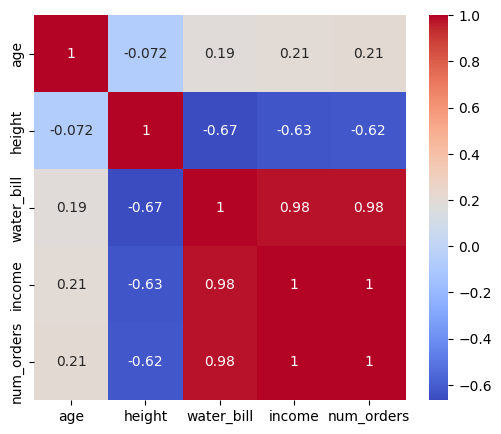

In [110]:
# Select only the numeric columns
numeric_columns = merged_database.select_dtypes(include='number')

# Compute correlation coefficient matrix
correlation_matrix = numeric_columns.corr()
print(correlation_matrix)

# Create the heatmap
plt.figure(figsize=(6,5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

<h5> Explorig categorical features/ target relationship

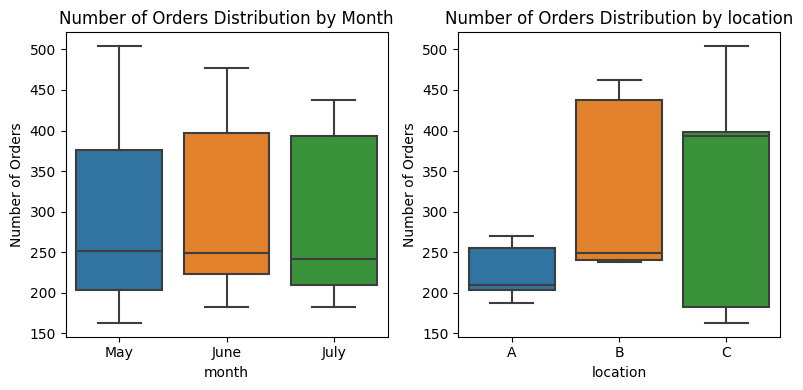

In [6]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4))

# Box plot for income distribution by location
sns.boxplot(x='month', y='num_orders', data=merged_database, ax=axes[0])
axes[0].set_title('Number of Orders Distribution by Month')
axes[0].set_ylabel('Number of Orders')

# Box plot for number of orders distribution by location
sns.boxplot(x='location', y='num_orders', data=merged_database, ax=axes[1])
axes[1].set_title('Number of Orders Distribution by location')
axes[1].set_ylabel('Number of Orders')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

From the above visual we can tell that our data;
* Has no outliers.
* Half of the number of orders for each month was below 250.
* May had the biggest variation in the orders.
* Location A 75% has least variation in number of orders while C has the highest variation in the number of orders


<h5> Checking for outliers in column age and height

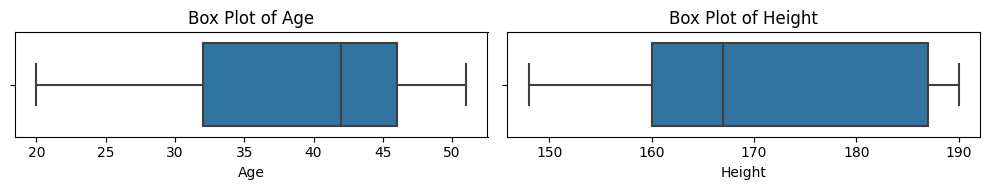

In [111]:
# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 2))

# Box plot for 'age'
sns.boxplot(x=merged_database['age'], ax=axes[0])
axes[0].set_title('Box Plot of Age')
axes[0].set_xlabel('Age')

# Box plot for 'height'
sns.boxplot(x=merged_database['height'], ax=axes[1])
axes[1].set_title('Box Plot of Height')
axes[1].set_xlabel('Height')

# Adjust spacing between subplots
plt.tight_layout()

# Display the plots
plt.show()

From the box plot:
* There are no outliers in our dataset.
* Half of the customers are below 42 of age.
* Half of the customers are below 168 height
* 75% of customers are below 46 yrs while 25% are below 32 yrs.
* 75% of customers are within 188 height while 25% are below 160 height.

In [113]:
# Return unique names for the customers in our database
merged_database.name.unique()

array(['Juan', 'Julia', 'Peter', 'John', 'Stella', 'Faith', 'Marcus',
       'Betty', 'Lynn'], dtype=object)

2. Split the data into a training and test set, creating two .csv files: **training_set.csv** and **test_set.csv**. Split as follows:

- Test_set contains data records for ['Stella', 'Peter']
- Train ['Juan', 'Julia', 'John', 'Faith', 'Marcus','Betty', 'Lynn']

In [114]:
# List of names for the test set
test_names = ['Stella', 'Peter']

# Filter the data based on the names for the test set
test_set = merged_database[merged_database['name'].isin(test_names)]

# Filter the data for the training set (excluding the names in the test set)
train_set = merged_database[~merged_database['name'].isin(test_names)]

# Save the test set and training set as separate CSV files in Task3_4 folder
test_set.to_csv('Task 3 _ 4/test_set.csv', index=False)
train_set.to_csv('Task 3 _ 4/training_set.csv', index=False)

In [115]:
# checking the size of our train and test data sets.
train_set.shape, test_set.shape

((21, 8), (6, 8))

* There are 21 records in train data and 6 records in test data.
* There are 8 columns in the both sets

3. Using a statistical or machine learning model, predict the number of orders that Peter and Stella make in May, June, and July.

In [116]:
# train columns
train_set.columns

Index(['name', 'age', 'height', 'location', 'water_bill', 'month', 'income',
       'num_orders'],
      dtype='object')

Steps:
* Split each data set (train and test) into two Dependent and independent.
* Build model with all the features to test.
* Drop one of the most correlated features from our train data and in test.
* Train model and compare which model performed best and after dropping which variable.
* model validation/ selection

In [117]:
# model features 
X_train_= train_set.drop(columns='num_orders') #dropping the depedent variable from train set
X_test_= test_set.drop(columns='num_orders') #dropping the depedent variable from test set

# Target feature/ dependent
y_train= train_set['num_orders']
y_test=test_set['num_orders']

In [118]:
# distinct locations in each set
train_locations = X_train_['location'].unique()
test_locations = X_test_['location'].unique()

print("The unique locations in the train dataset are:\n{}".format(train_locations))
print("The unique locations in the test dataset are:\n{}".format(test_locations))

The unique locations in the train dataset are:
['A' 'B' 'C']
The unique locations in the test dataset are:
['A']


*All locations in test set are present in train set. This check helps ensure that you don't encounter errors related to missing or unseen locations when training the model with the location feature and making predictions.*

In [119]:
# Dropping name from the train and test
X_train=X_train_.drop(columns=['name'])
X_test= X_test_.drop(columns=['name'])

water_bill and income are highly correlated and could cause multicollinearity hence, I will drop one. But I will test for this while performing the model validation. If the proof proves to be true, then I will drop one of the features, test the model performance, and validate it.

#### Model building

In [120]:
# Dropping correlated features and unwanted columns from the train and test
X_train=X_train_.drop(columns=['name'])
X_test= X_test_.drop(columns=['name'])

# Define the categorical columns and numeric columns
categorical_cols = ['location', 'month']

# Get the numeric columns by excluding the categorical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create a pipeline for different regression algorithm
pipelines = {
    'Linear Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', LinearRegression())
    ]),
    'Decision Tree': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', RandomForestRegressor())
    ]),
    'XGBoost': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', XGBRegressor())
    ]),
    
    'Ridge Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', Ridge())
    ])
    
}

# Train and evaluate each regression algorithm
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)  # fitting model
    y_pred = pipeline.predict(X_test)  # predicting X_test
    mae = mean_absolute_error(y_test, y_pred)  # calculate mae
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    results[name] = (mae, r2)

# Find the algorithm with the lowest MAE and highest R-squared
best_algorithm_mae = min(results, key=lambda k: results[k][0])
best_algorithm_r2 = max(results, key=lambda k: results[k][1])
best_mae, best_r2 = results[best_algorithm_mae]

# Print the results
print("Performance of different regression algorithms:")
for name, (mae, r2) in results.items():
    print("{} - MAE: {:.4f}, R-squared: {:.4f}".format(name, mae, r2))
    
print("\nThe best algorithm based on MAE is {} with MAE of {:.4f}".format(best_algorithm_mae, best_mae))
print("The best algorithm based on R-squared is {} with R-squared of {:.4f}".format(best_algorithm_r2, best_r2))

Performance of different regression algorithms:
Linear Regression - MAE: 3.7464, R-squared: 0.9830
Decision Tree - MAE: 11.1667, R-squared: 0.8427
Random Forest - MAE: 47.9600, R-squared: -1.4698
XGBoost - MAE: 122.5754, R-squared: -12.9145
Ridge Regression - MAE: 5.8349, R-squared: 0.9568

The best algorithm based on MAE is Linear Regression with MAE of 3.7464
The best algorithm based on R-squared is Linear Regression with R-squared of 0.9830


#### Training with the best performed model

In [23]:
# Create a pipeline for Linear Regression
pipeline = Pipeline([
    ('preprocess', ColumnTransformer([
        ('encoder', OneHotEncoder(drop='first'), categorical_cols), #converting categorical to numerics
        ('scaler', StandardScaler(), numeric_cols) # standadizing numerical values
    ])),
    ('regressor', LinearRegression())
])

# Fit the Linear Regression model
linear_regression_model=pipeline.fit(X_train, y_train)

#### Model evaluation

In [24]:
# Predict on the test set
y_pred = linear_regression_model.predict(X_test)

# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Linear Regression - MAE: {:.4f}".format(mae))
print("Linear Regression - R-squared: {:.4f}".format(r2))

Linear Regression - MAE: 3.7464
Linear Regression - R-squared: 0.9830


- The model returns  R2 value of 98.3%, so it fit our data test very well.
- The model has a Mean absolute error of 3.7464 which very small value, which suggests a small discrepancy between the predicted and actual values.

#### Model validation

Linear regression make following assumptions;
- Ther is linear relationship between the dependent and independent variables.
- Little or no multicollinearity
- Normality of the residuals
- Homoscedasticity of errors or equal variances

#### Testing the above from our model.

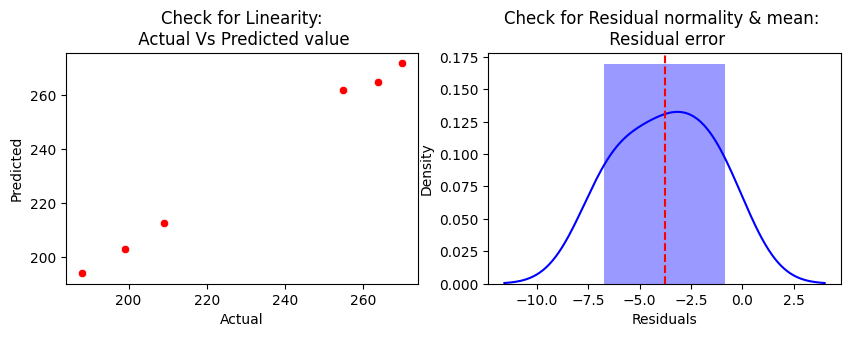

In [50]:
# Check for Linearity
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test, y=y_pred, ax=ax, color='r') # plot scatter
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax=ax, color='b')
ax.axvline((y_test - y_pred).mean(), color='r', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error')
ax.set_xlabel('Residuals');

In our model 
- The actual vs predicted plot is linear model is capturing the underlying linear relationship between the features and the target variable. Hence linear assumption satisfied.
- Residuals are normaly distributed hence normality assumptions satisfied.


In [45]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- r2)
VIF

58.98346661580339

- Variance inflation factor value is greator than 5, so there is multicollearity. Therefore we need to drop some of the highly correlated features.

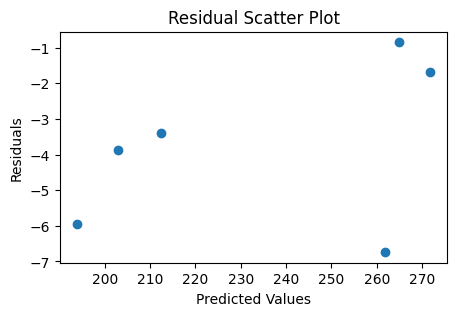

In [51]:
plt.figure(figsize=(5, 3))
#Check for Homoscedasticity

residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Scatter Plot')
plt.show()

- The plot exhibit heteroscedastic, hence unsatisfactory model.

#### Dropping the correlated features and retraing the model.
*We will drop the "income" feature, and later the "water bill" feature, to evaluate model performance. We will then validate  models and select the best one.*

In [71]:
# Dropping correlated features and unwanted columns from the train and test (income)
X_train=X_train_.drop(columns=['name','income'])
X_test= X_test_.drop(columns=['name','income'])

# Define the categorical columns and numeric columns
categorical_cols = ['location', 'month']

# Get the numeric columns by excluding the categorical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create a pipeline for different regression algorithm
pipelines = {
    'Linear Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', LinearRegression())
    ]),
    'Decision Tree': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', RandomForestRegressor())
    ]),
    'XGBoost': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', XGBRegressor())
    ]),
    
    'Ridge Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', Ridge())
    ])
    
}

# Train and evaluate each regression algorithm
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)  # fitting model
    y_pred = pipeline.predict(X_test)  # predicting X_test
    mae = mean_absolute_error(y_test, y_pred)  # calculate mae
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    results[name] = (mae, r2)

# Find the algorithm with the lowest MAE and highest R-squared
best_algorithm_mae = min(results, key=lambda k: results[k][0])
best_algorithm_r2 = max(results, key=lambda k: results[k][1])
best_mae, best_r2 = results[best_algorithm_mae]

# Print the results
print("Performance of different regression algorithms:")
for name, (mae, r2) in results.items():
    print("{} - MAE: {:.4f}, R-squared: {:.4f}".format(name, mae, r2))
    
print("\nThe best algorithm based on MAE is {} with MAE of {:.4f}".format(best_algorithm_mae, best_mae))
print("The best algorithm based on R-squared is {} with R-squared of {:.4f}".format(best_algorithm_r2, best_r2))

Performance of different regression algorithms:
Linear Regression - MAE: 32.3436, R-squared: -0.2835
Decision Tree - MAE: 32.1667, R-squared: -0.3033
Random Forest - MAE: 93.8800, R-squared: -7.5818
XGBoost - MAE: 133.9606, R-squared: -15.5453
Ridge Regression - MAE: 15.2713, R-squared: 0.7336

The best algorithm based on MAE is Ridge Regression with MAE of 15.2713
The best algorithm based on R-squared is Ridge Regression with R-squared of 0.7336


#### Traing on the best performing model (Ridge)

In [86]:
# Create a pipeline for Ridge Regression after droping income
pipeline = Pipeline([
    ('preprocess', ColumnTransformer([
        ('encoder', OneHotEncoder(drop='first'), categorical_cols), #converting categorical to numerics
        ('scaler', StandardScaler(), numeric_cols) # standadizing numerical values
    ])),
    ('regressor', Ridge())
])

# Fit the Linear Regression model
ridge_regression_model=pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = ridge_regression_model.predict(X_test)

# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("Ridge Regression - MAE: {:.4f}".format(mae))
print("Ridge Regression - R-squared: {:.4f}".format(r2))

Ridge Regression - MAE: 15.2713
Ridge Regression - R-squared: 0.7336


- The model returns  R2 value of 73.36%, so it fit our data test very well. Though we can work on it to improve our model performance.

#### Validating our second model trained after droping one of the correlated features income

residual mean = 5.356213713612192


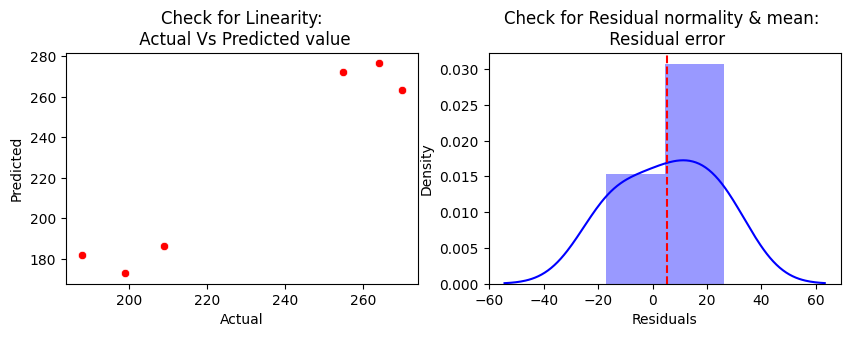

In [57]:
# Check for Linearity
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test, y=y_pred, ax=ax, color='r') # plot scatter
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax=ax, color='b')
ax.axvline((y_test - y_pred).mean(), color='r', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error')
ax.set_xlabel('Residuals')
print('residual mean = {}'.format((y_test - y_pred).mean()));

From the above graph ;
- There is a linearity between predicted and the actual values which model is capturing the underlying linear relationship between the features and the target variable.
- Residuals are normally distributed, hence normality assumption satisfied.

In [121]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- r2)
VIF

23.135564551560147

- VIF less than 5 (specifically 3.7539) suggests minimal multicollinearity, satisfying the assumption of no or little collinearity.

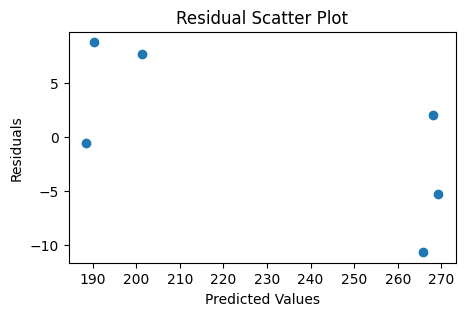

In [122]:
plt.figure(figsize=(5, 3))
#Check for Homoscedasticity

residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Scatter Plot')
plt.show()

- Residual does not vary much as the value of the predicted variable changes hence satisifies Homoscedasticity assumption.

#### Droping water bill

In [62]:
# Dropping correlated features and unwanted columns from the train and test (water_bill)
X_train=X_train_.drop(columns=['name','water_bill'])
X_test= X_test_.drop(columns=['name','water_bill'])

# Define the categorical columns and numeric columns
categorical_cols = ['location', 'month']

# Get the numeric columns by excluding the categorical columns
numeric_cols = [col for col in X_train.columns if col not in categorical_cols]

# Create a pipeline for different regression algorithm
pipelines = {
    'Linear Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', LinearRegression())
    ]),
    'Decision Tree': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', DecisionTreeRegressor())
    ]),
    'Random Forest': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', RandomForestRegressor())
    ]),
    'XGBoost': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', XGBRegressor())
    ]),
    
    'Ridge Regression': Pipeline([
        ('preprocess', ColumnTransformer([
            ('encoder', OneHotEncoder(drop='first'), categorical_cols),
            ('scaler', StandardScaler(), numeric_cols)
        ])),
        ('regressor', Ridge())
    ])
    
}

# Train and evaluate each regression algorithm
results = {}
for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)  # fitting model
    y_pred = pipeline.predict(X_test)  # predicting X_test
    mae = mean_absolute_error(y_test, y_pred)  # calculate mae
    r2 = r2_score(y_test, y_pred)  # Calculate R-squared
    results[name] = (mae, r2)

# Find the algorithm with the lowest MAE and highest R-squared
best_algorithm_mae = min(results, key=lambda k: results[k][0])
best_algorithm_r2 = max(results, key=lambda k: results[k][1])
best_mae, best_r2 = results[best_algorithm_mae]

# Sort the results based on MAE in ascending order
sorted_results_mae = sorted(results.items(), key=lambda x: x[1][0])

# Print the results
print("Performance of different regression algorithms (sorted based on MAE):")
for name, (mae, r2) in sorted_results_mae:
    print("{} - MAE: {:.4f}, R-squared: {:.4f}".format(name, mae, r2))
    
print("\nThe best algorithm based on MAE is {} with MAE of {:.4f}".format(best_algorithm_mae, best_mae))
print("The best algorithm based on R-squared is {} with R-squared of {:.4f}".format(best_algorithm_r2, best_r2))

Performance of different regression algorithms (sorted based on MAE):
Linear Regression - MAE: 3.4061, R-squared: 0.9853
Ridge Regression - MAE: 9.4175, R-squared: 0.8796
Random Forest - MAE: 76.0500, R-squared: -4.7645
XGBoost - MAE: 123.0612, R-squared: -13.0126
Decision Tree - MAE: 156.5000, R-squared: -22.4221

The best algorithm based on MAE is Linear Regression with MAE of 3.4061
The best algorithm based on R-squared is Linear Regression with R-squared of 0.9853


#### Training with best performing model

In [66]:
# Create a pipeline for Linear Regression
pipeline = Pipeline([
    ('preprocess', ColumnTransformer([
        ('encoder', OneHotEncoder(drop='first'), categorical_cols), #converting categorical to numerics
        ('scaler', StandardScaler(), numeric_cols) # standadizing numerical values
    ])),
    ('regressor', LinearRegression())
])

# Fit the Linear Regression model
linear_regression_model2=pipeline.fit(X_train, y_train)

# Predict on the test set
y_pred = linear_regression_model2.predict(X_test)

# Calculate the performance metrics
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the results
print("linear regression 2 - MAE: {:.4f}".format(mae))
print("linear regression 2 - R-squared: {:.4f}".format(r2))

linear regression 2 - MAE: 3.4061
linear regression 2 - R-squared: 0.9853


#### Validating the 3rd model trained after droping one of the correlated feature 'water_bill'

residual mean = -3.406135953889693


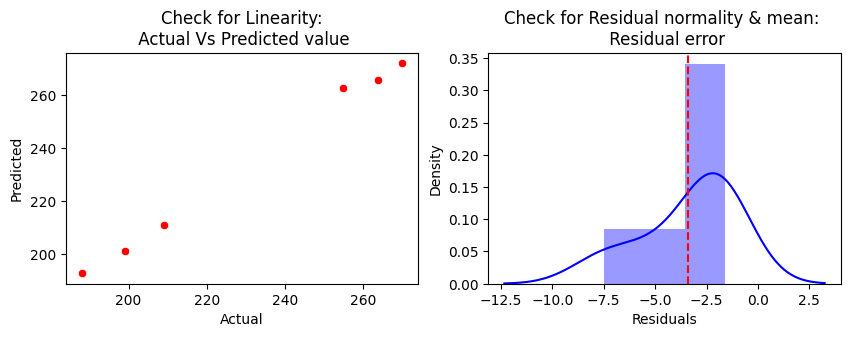

In [67]:
# Check for Linearity
f = plt.figure(figsize=(10, 3))
ax = f.add_subplot(121)
sns.scatterplot(x=y_test, y=y_pred, ax=ax, color='r') # plot scatter
ax.set_title('Check for Linearity:\n Actual Vs Predicted value')
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')

# Check for Residual normality & mean
ax = f.add_subplot(122)
sns.distplot((y_test - y_pred), ax=ax, color='b')
ax.axvline((y_test - y_pred).mean(), color='r', linestyle='--')
ax.set_title('Check for Residual normality & mean: \n Residual error')
ax.set_xlabel('Residuals')
print('residual mean = {}'.format((y_test - y_pred).mean()));

From the above graph ;
- There is a linearity between predicted and the actual values which model is capturing the underlying linear relationship between the features and the target variable.
- Residuals are left skewed , hence normality assumption not satisfied.

In [68]:
# Check for Multicollinearity
#Variance Inflation Factor
VIF = 1/(1- r2)
VIF

67.83973360737832

- Variance Inflation Factor is greator than 5 which suggest multicollinearity, which can affect the learning of the model and its stability.

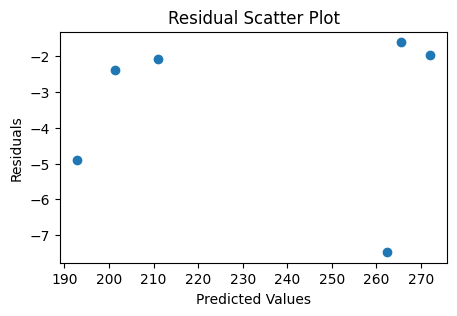

In [69]:
plt.figure(figsize=(5, 3))
#Check for Homoscedasticity

residuals = y_test - y_pred
# Scatter plot of residuals
plt.scatter(y_pred, residuals)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Scatter Plot')
plt.show()

- The plot exhibit heteroscedastic, hence unsatisfactory model. This indicates that the model is not effectively capturing the true variability of the target variable

#### Model selection.

Based on the above model  evaluations and validations, its clear after droping one of the highly correlated features (income) we were able to come up with a more stable model trained using Ridge algorithim.

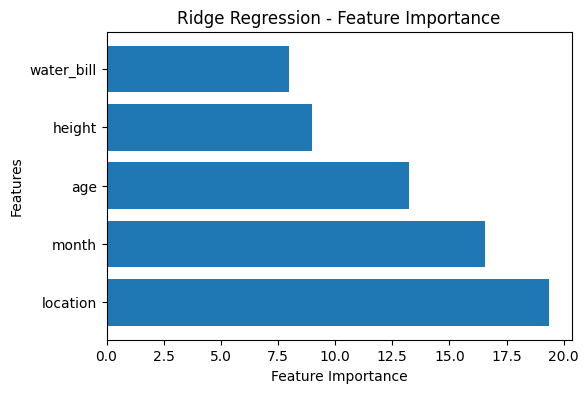

In [78]:
# Get the feature names
feature_names = categorical_cols + numeric_cols

# Get the coefficients from the Linear Regression model
coefficients = ridge_regression_model.named_steps['regressor'].coef_

# Create a dictionary to store feature importance
feature_importance = dict(zip(feature_names, abs(coefficients)))

# Sort the feature importance in descending order
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Plot the feature importance
plt.figure(figsize=(6, 4))
plt.barh(range(len(sorted_importance)), sorted_importance.values(), align='center')
plt.yticks(range(len(sorted_importance)), sorted_importance.keys())
plt.xlabel('Feature Importance')
plt.ylabel('Features')
plt.title('Ridge Regression - Feature Importance')
plt.show()

- Location is the best feature in predicting our target while water bill seems to be the least predictor.

In [88]:
feature_names= X_train.columns
feature_names

Index(['age', 'height', 'location', 'water_bill', 'month'], dtype='object')

In [90]:
# save the model 
joblib.dump(ridge_regression_model, 'models/pipeline.pkl')

# saving the features used in training
joblib.dump(feature_names, 'models/features')

['models/features']

In [79]:
y_pred

array([272.24765189, 181.85658735, 276.49765189, 186.10658735,
       263.27265189, 172.88158735])

In [92]:
test_set

,name,age,height,location,water_bill,month,income,num_orders
2,Peter,42,167,A,140,May,1300,255
4,Stella,33,160,A,91,May,955,188
11,Peter,42,167,A,140,June,1320,264
13,Stella,33,160,A,91,June,1050,209
20,Peter,42,167,A,140,July,1350,270
22,Stella,33,160,A,91,July,1000,199


In [104]:
# convert y_pred to a dataframe then concat it with the train set to get the predictions Peter and Stella make in May, June, and July.
# Convert y_pred to DataFrame
y_pred_df = pd.DataFrame(y_pred, columns=['pred_num_orders'])

# Adding predicted column to test_set dataframe
test_df=test_set.copy().reset_index(drop=True) #creating a copy of the test_set data
test_df['pred_num_orders']=y_pred_df['pred_num_orders']

# return name, month and the predictions
prediction_df= test_df[['name','month', 'num_orders','pred_num_orders']]
prediction_df

,name,month,num_orders,pred_num_orders
0,Peter,May,255,272.247652
1,Stella,May,188,181.856587
2,Peter,June,264,276.497652
3,Stella,June,209,186.106587
4,Peter,July,270,263.272652
5,Stella,July,199,172.881587
